In [2]:
from google.colab import files
uploaded = files.upload()

Saving customer_churn_dataset-testing-master.csv to customer_churn_dataset-testing-master.csv
Saving customer_churn_dataset-training-master.csv to customer_churn_dataset-training-master.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve)
from imblearn.over_sampling import SMOTE
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [31]:
# --- 1. Load Data ---
df_train = pd.read_csv("/content/customer_churn_dataset-training-master.csv")
df_test = pd.read_csv("/content/customer_churn_dataset-testing-master.csv")
df_train.isnull().sum()
print(f"Train: {df_train.isnull().sum()} \n Test: {df_test.isnull().sum()}")

df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

print(f"Dataset Loaded ✅ | Shape: {df.shape}")

Train: CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64 
 Test: CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64
Dataset Loaded ✅ | Shape: (505207, 12)


In [26]:
df.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn,Customer_Segment
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0,High Value
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0,Regular
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0,Regular
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0,Regular
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0,Regular


In [32]:
print(df.duplicated().sum())

np.int64(0)

In [33]:
print(df.info())
print("\n", df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505207 entries, 0 to 505206
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         505206 non-null  float64
 1   Age                505206 non-null  float64
 2   Gender             505206 non-null  object 
 3   Tenure             505206 non-null  float64
 4   Usage Frequency    505206 non-null  float64
 5   Support Calls      505206 non-null  float64
 6   Payment Delay      505206 non-null  float64
 7   Subscription Type  505206 non-null  object 
 8   Contract Length    505206 non-null  object 
 9   Total Spend        505206 non-null  float64
 10  Last Interaction   505206 non-null  float64
 11  Churn              505206 non-null  float64
dtypes: float64(9), object(3)
memory usage: 46.3+ MB
None

           CustomerID            Age         Tenure  Usage Frequency  \
count  505206.000000  505206.000000  505206.000000    505206.000000   
m

In [5]:
df.drop("CustomerID", axis=1, inplace=True)

# Fill numeric NA with median
for col in df.select_dtypes(include=[np.number]).columns.drop("Churn"):
    df[col].fillna(df[col].median(), inplace=True)

# Fill categorical NA with mode
for col in df.select_dtypes(include="object").columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

df.dropna(subset=["Churn"], inplace=True)
print("Missing values handled ✅")

Missing values handled ✅


In [6]:
# --- 3. Feature Engineering ---
high_value_cut = df["Total Spend"].quantile(0.8)
df["Customer_Segment"] = np.where(df["Total Spend"] >= high_value_cut,
                                  "High Value", "Regular")

In [8]:
# --- 4. Prepare Features ---
X = df.drop(["Churn", "Customer_Segment"], axis=1)
y = df["Churn"]


# Encode categoricals
for col in ["Gender", "Subscription Type", "Contract Length"]:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balance with SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

print("Data ready for Random Forest ✅")

Data ready for Random Forest ✅


In [9]:
# --- 5. Train Random Forest ---
rf = RandomForestClassifier(
    n_estimators=150, max_depth=12,
    min_samples_split=8, min_samples_leaf=4,
    max_features="sqrt", random_state=42, n_jobs=-1
)
rf.fit(X_train_bal, y_train_bal)

RandomForestClassifier(max_depth=12, min_samples_leaf=4, min_samples_split=8,
                       n_estimators=150, n_jobs=-1, random_state=42)

In [10]:
# --- 6. Evaluate Model ---
rf_pred = rf.predict(X_test_scaled)
rf_proba = rf.predict_proba(X_test_scaled)[:, 1]

print("\n--- Random Forest Classification Report ---\n")
print(classification_report(y_test, rf_pred))

metrics = {
    "Accuracy": accuracy_score(y_test, rf_pred),
    "Precision": precision_score(y_test, rf_pred),
    "Recall": recall_score(y_test, rf_pred),
    "F1-Score": f1_score(y_test, rf_pred),
    "AUC-ROC": roc_auc_score(y_test, rf_proba)
}
print("\nMetrics Summary:", metrics)


--- Random Forest Classification Report ---

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92     44943
         1.0       0.90      0.99      0.94     56099

    accuracy                           0.93    101042
   macro avg       0.94      0.93      0.93    101042
weighted avg       0.94      0.93      0.93    101042


Metrics Summary: {'Accuracy': 0.9337206310247224, 'Precision': 0.8984674947572189, 'Recall': 0.9928162712347813, 'F1-Score': 0.9432885366122162, 'AUC-ROC': np.float64(0.9534503934419256)}


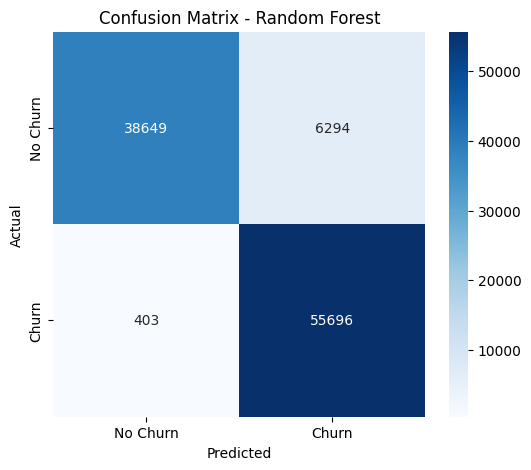

In [11]:
# --- 7. Confusion Matrix ---
cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

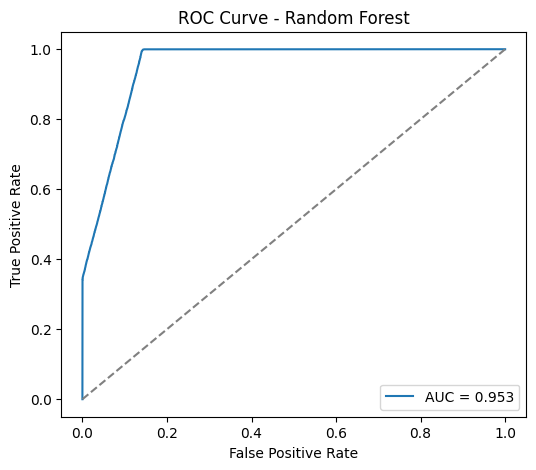

In [13]:
# --- 8. ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, rf_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {metrics['AUC-ROC']:.3f}")
plt.plot([0,1],[0,1],'--',color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

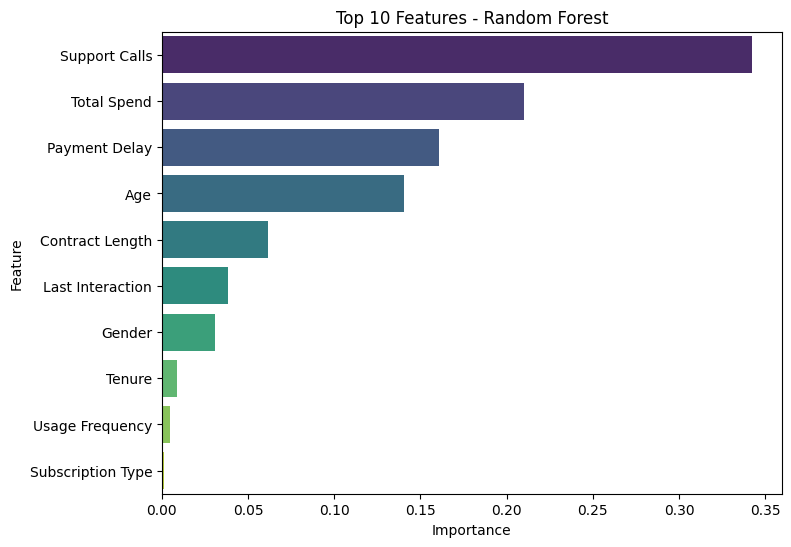

In [14]:
# --- 9. Feature Importance ---
fi = pd.DataFrame({"Feature": X.columns, "Importance": rf.feature_importances_})
fi = fi.sort_values("Importance", ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(data=fi.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Features - Random Forest")
plt.show()

In [25]:
# --- 10. Save Model ---
filename = f"RandomForest_{metrics['Accuracy']:.2f}acc_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl"
with open(filename, "wb") as f:
    pickle.dump(rf, f)

print(f"\n✅ Random Forest model saved as '{filename}'")


✅ Random Forest model saved as 'RandomForest_0.93acc_2025-09-07_13-03-28.pkl'
